In [1]:
import pandas as pd
import numpy as np
import math
from itertools import cycle

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [3]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

# Setup

## variables

In [4]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

In [5]:
# Functions

In [6]:
def r2(actual: np.ndarray, predicted: np.ndarray):
    """ R2 Score """
    return r2_score(actual, predicted)

def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: int, featurecount: int):
    """ R2 Score """
    return 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

def mse(actual, predicted):
    return mean_squared_error(actual, predicted)

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def model_results(actual, predicted, rowcount, featurecount):
    print('r-squared: ', round(r2(actual, predicted),4))
    print('adj r-squared', round(adjr2(actual,predicted,rowcount, featurecount),4))
    print('mse: ', round(mse(actual, predicted),4))
    print('rmse: ', round(rmse(actual, predicted),4))
    print('rmse: ', eval_measures.rmse(actual,predicted,axis=0))

In [7]:
def get_fed_chair():
    df = pd.read_csv('./data/Fed_Chair.csv', parse_dates=['Start_Date','End_Date'])
    df['End_Date'].fillna(pd.Timestamp.now().normalize(), inplace=True)
    df = df[(df['Start_Date'] >= '1945-01-01')]
    return df

def fed_chair(df, chair_df):
    
    df.reset_index(inplace=True)

    df['chair_name'] = None
    for i, row in chair_df.iterrows():
        df['chair_name'] = df['chair_name'].where((df['DATE'] < row['Start_Date']) | (df['DATE'] > row['End_Date']), row['Name'] )
    
    df.set_index('DATE',inplace=True)
    return df

In [8]:
def get_recession():
    recession_df = pd.read_csv('./data/FRED_Recession_Bars.csv', parse_dates=['Peak_Date','Trough_Date'])
    return recession_df[(recession_df['Peak_Date'] >= '1945-01-01')]


def add_recession_feature(date, recession_df):
    for i,row in recession_df.iterrows():
        if row['Peak_Date'] <= date <= row['Trough_Date']:
            return True
    return False


In [9]:


def load_taylor():
    
    gdpc1_df = pd.read_csv('./data/GDPC1.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpc1_df:', gdpc1_df.shape)
    gdppot_df = pd.read_csv('./data/GDPPOT.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdppot_df:', gdppot_df.shape)
    gdpdef_df = pd.read_csv('./data/GDPDEF.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpdef_df:', gdpdef_df.shape)
    fed_df = pd.read_csv('./data/FEDFUNDS.csv', parse_dates=['observation_date'], skiprows=10)
    print('fed_df:', fed_df.shape)
    
    
    taylor_df = gdpc1_df.merge(gdppot_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                        .merge(gdpdef_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                        .merge(fed_df, how='outer', left_on='observation_date', right_on='observation_date')

    taylor_df.dropna(inplace=True)
    taylor_df
    
    
    #taylor_df = pd.DataFrame()
    taylor_df['ffef_tr'] = taylor_df['GDPDEF_PC1'] + 2    \
                            +0.5*(taylor_df['GDPDEF_PC1'] - 2)    \
                            +0.5*(taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100

    taylor_df['gap_inf'] = 0.5*(taylor_df['GDPDEF_PC1'] - 2) 
    taylor_df['gap_gdp'] = 0.5*(taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100

    taylor_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    
    
    r_df = get_recession()
    #$taylor_df.reset_index(inplace=True)
    taylor_df['recession_flag'] = taylor_df['DATE'].apply(add_recession_feature, args=(r_df,))
    taylor_df.set_index('DATE',inplace=True)
    #taylor_df
    #taylor_df = taylor_df.set_index('DATE')
    #taylor_df = add_recession_feature(taylor_df,r_df)
    
    f_df = get_fed_chair()
    fed_chair(taylor_df, f_df)
    
    
    return taylor_df



def load_misery():
    
    t_df = pdr.DataReader(['FEDFUNDS','CPIAUCSL', 'UNRATE'], data_source, start_date)
    t_df.dropna(inplace=True)
    print('t_df:', t_df.shape)

    #u_df = pd.read_csv('./data/CPIAUCSL.csv', parse_dates=['observation_date'], skiprows=10)
    #u_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    #u_df.set_index('DATE', inplace=True)
    u_df = pd.read_csv('./data/CPIAUCSL_PC1.csv', parse_dates=['DATE'])
    #u_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    u_df.set_index('DATE', inplace=True)
    print('u_df:', u_df.shape)

    misery_df = pd.merge(t_df,u_df, left_index=True, right_index=True )
    #misery_df['m_index'] = abs(misery_df['CPIAUCSL_CH1']) + misery_df['UNRATE']
    #misery_df['m_index'] = (misery_df['CPIAUCSL_CH1']) + misery_df['UNRATE']
    misery_df['m_index'] = (misery_df['CPIAUCSL_PC1']) + misery_df['UNRATE']
    print('misery_df:', misery_df.shape)  
    
    return misery_df



def time_split(df):
    t_df = df.copy()

    # Split Data
    splt_index = round(t_df.shape[0] * 0.8)
    train_df = t_df[:splt_index]
    print('train_df: ' , train_df.shape)

    end_index = splt_index - t_df.shape[0]
    test_df = t_df[end_index:]
    print('test_df: ' , test_df.shape)
    
    return train_df, test_df

# Dataset FRED Data

In [10]:
taylor_df = load_taylor()
taylor_df

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


GDPC1        GDPPOT  GDPDEF_PC1  FEDFUNDS    ffef_tr  gap_inf  \
DATE                                                                            
1954-07-01   2880.482   2727.099666         0.7      0.80   4.862188    -0.65   
1954-10-01   2936.852   2743.726730         0.8      0.85   5.719397    -0.60   
1955-01-01   3020.746   2760.136280         1.0      1.39   7.220957    -0.50   
1955-04-01   3069.910   2777.950765         1.3      1.43   8.204939    -0.35   
1955-07-01   3111.379   2795.471543         1.9      1.68   9.500343    -0.05   
...               ...           ...         ...       ...        ...      ...   
2022-04-01  21708.160  20153.810000         7.7      0.33  16.406219     2.85   
2022-07-01  21851.134  20245.660000         7.3      1.68  15.914983     2.65   
2022-10-01  21989.981  20334.210000         6.4      3.08  14.671392     2.20   
2023-01-01  22112.329  20420.680000         5.3      4.33  13.092000     1.65   
2023-04-01  22225.350  20511.890000         3.5      4.83  10.426748     0.75   

             gap_gdp  recession_flag chair_name  
DATE                                             
1954-07-01  2.812188           False     Martin  
1954-10-01  3.519397           False     Martin  
1955-01-01  4.720957           False     Martin  
1955-04-01  5.254939           False     Martin  
1955-07-01  5.650343           False     Martin  
...              ...             ...        ...  
2022-04-01  3.856219           False     Powell  
2022-07-01  3.964983           False     Powell  
2022-10-01  4.071392           False     Powell  
2023-01-01  4.142000           False     Powell  
2023-04-01  4.176748           False     Powell  

[276 rows x 9 columns]

In [11]:
misery_df = load_misery()
misery_df

t_df: (832, 3)
u_df: (909, 1)
misery_df: (831, 5)


FEDFUNDS  CPIAUCSL  UNRATE  CPIAUCSL_PC1  m_index
DATE                                                         
1954-07-01      0.80    26.860     5.8       0.26129  6.06129
1954-08-01      1.22    26.850     6.0       0.00000  6.00000
1954-09-01      1.07    26.810     6.1      -0.29751  5.80249
1954-10-01      0.85    26.720     5.7      -0.85343  4.84657
1954-11-01      0.83    26.780     5.3      -0.26071  5.03929
...              ...       ...     ...           ...      ...
2023-05-01      5.06   303.294     3.7       4.12884  7.82884
2023-06-01      5.08   303.841     3.6       3.09200  6.69200
2023-07-01      5.12   304.348     3.5       3.29908  6.79908
2023-08-01      5.33   306.269     3.8       3.70750  7.50750
2023-09-01      5.33   307.481     3.8       3.68990  7.48990

[831 rows x 5 columns]

In [12]:
recession_df = get_recession()
recession_df

Peak_Date Trough_Date
21 1945-02-01  1945-10-01
22 1948-11-01  1949-10-01
23 1953-07-01  1954-05-01
24 1957-08-01  1958-04-01
25 1960-04-01  1961-02-01
26 1969-12-01  1970-11-01
27 1973-11-01  1975-03-01
28 1980-01-01  1980-07-01
29 1981-07-01  1982-11-01
30 1990-07-01  1991-03-01
31 2001-03-01  2001-11-01
32 2007-12-01  2009-06-01
33 2020-02-01  2020-04-01

In [215]:
chair_df = get_fed_chair()
chair_df

Name                      Full_Name Start_Date   End_Date  \
7      McCabe               Thomas B. McCabe 1948-04-15 1951-03-31   
8      Martin  William McChesney Martin, Jr. 1951-04-02 1970-01-31   
9       Burns                Arthur F. Burns 1970-02-01 1978-01-31   
10     Miller              G. William Miller 1978-03-08 1979-08-06   
11    Volcker                Paul A. Volcker 1979-08-06 1987-08-11   
12  Greenspan                 Alan Greenspan 1987-08-11 2006-01-31   
13   Bernanke                Ben S. Bernanke 2006-02-01 2014-01-31   
14     Yellen                Janet L. Yellen 2014-02-03 2018-02-03   
15     Powell               Jerome H. Powell 2018-02-05 2023-11-15   

                                                Title  
7   Chairman of the Board of Governors of the Fede...  
8   Chairman of the Board of Governors of the Fede...  
9   Chairman of the Board of Governors of the Fede...  
10  Chairman of the Board of Governors of the Fede...  
11  Chairman of the Board of Governors of the Fede...  
12  Chairman of the Board of Governors of the Fede...  
13  Chairman of the Board of Governors of the Fede...  
14  Chair of the Board of Governors of the Federal...  
15  Chair of the Board of Governors of the Federal...

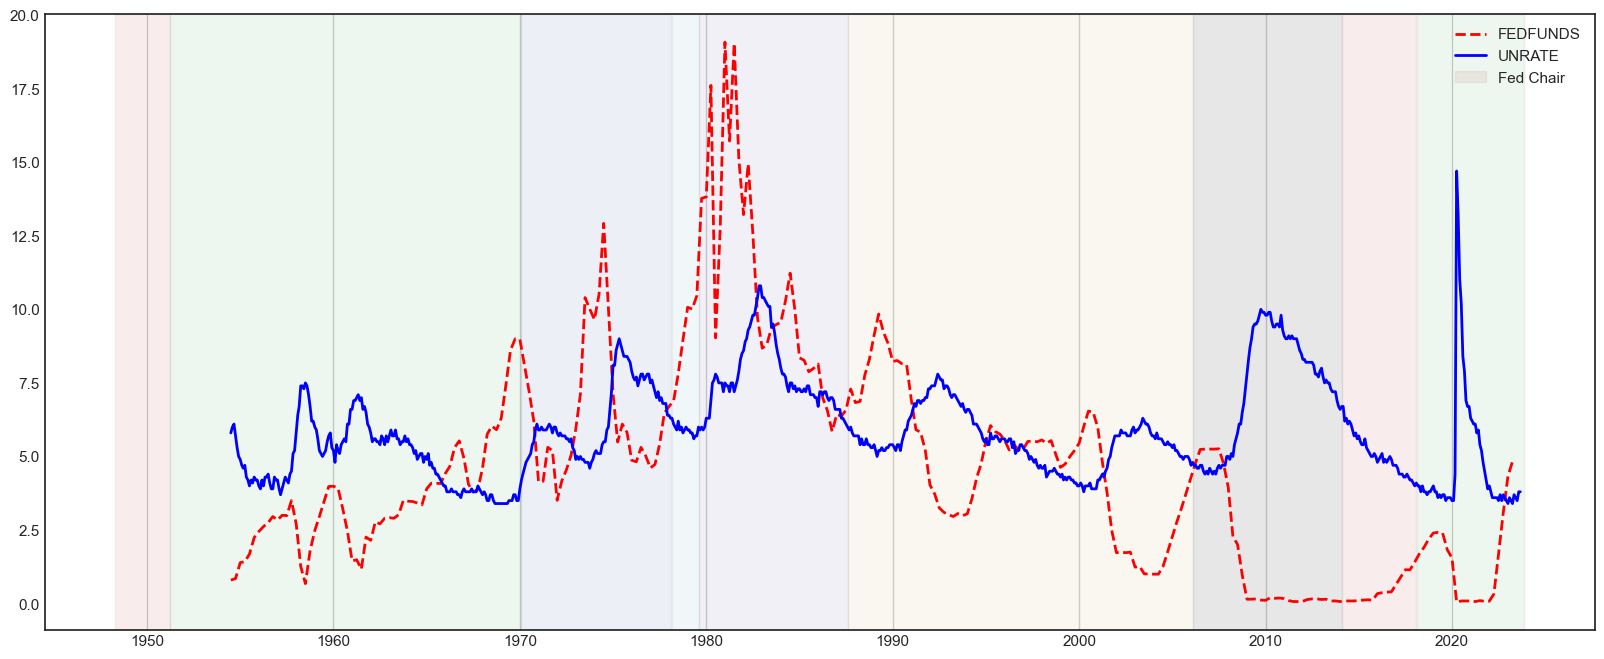

In [244]:
cycol = cycle('rgbcmyk')

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)
ax.plot(misery_df.index, misery_df['UNRATE'], color='blue',linewidth=2)

# Plotting recession bars
for i,row in chair_df.iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1)
    #print()
    
ax.legend(["FEDFUNDS","UNRATE",'Fed Chair'])
plt.show()

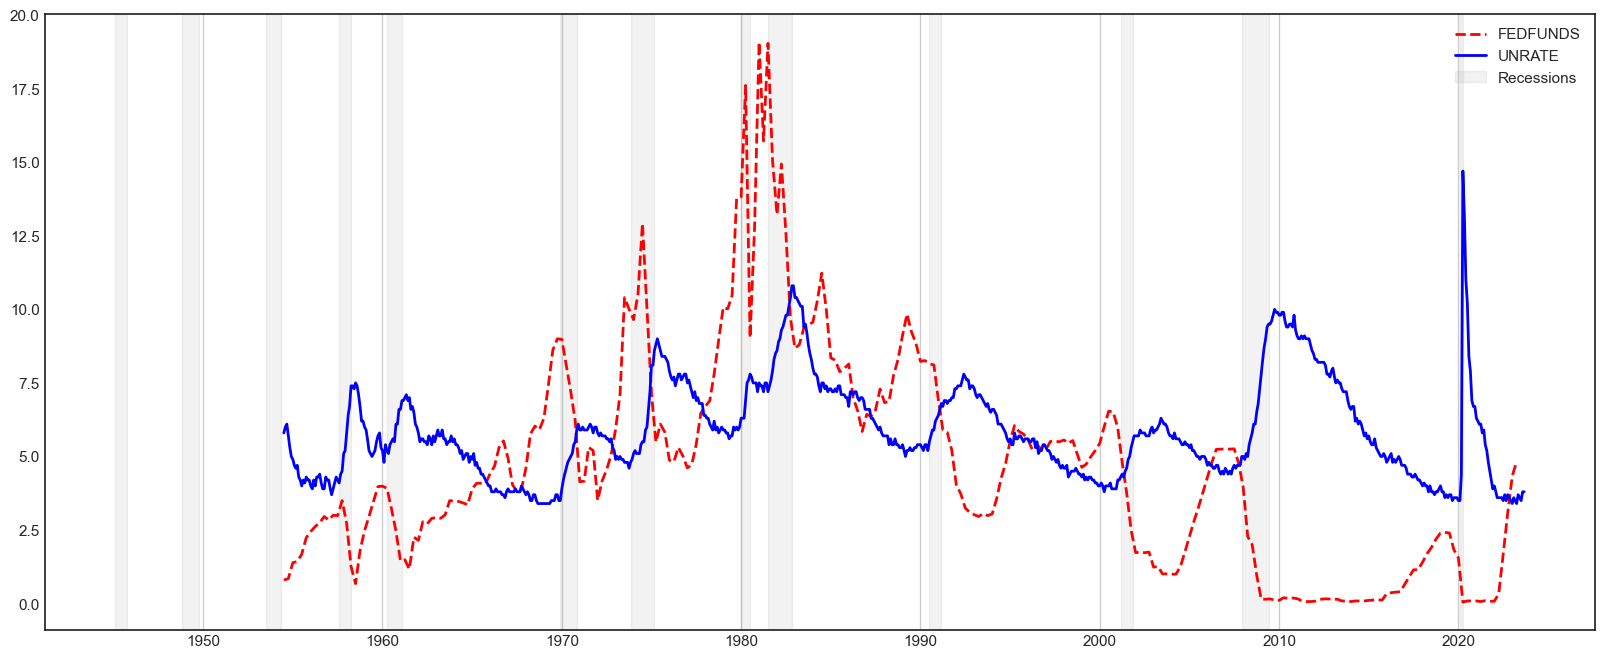

In [15]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()


# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], linestyle='--', color='red',linewidth=2)
ax.plot(misery_df.index, misery_df['UNRATE'], color='blue',linewidth=2)

# Plotting recession bars
for i,row in recession_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
    #print()
    
ax.legend(["FEDFUNDS","UNRATE",'Recessions'])
plt.show()

# Regression Model

## Load Data

In [16]:
taylor_df = load_taylor()
taylor_df.info()

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 1954-07-01 to 2023-04-01
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GDPC1           276 non-null    float64
 1   GDPPOT          276 non-null    float64
 2   GDPDEF_PC1      276 non-null    float64
 3   FEDFUNDS        276 non-null    float64
 4   ffef_tr         276 non-null    float64
 5   gap_inf         276 non-null    float64
 6   gap_gdp         276 non-null    float64
 7   recession_flag  276 non-null    bool   
 8   chair_name      276 non-null    object 
dtypes: bool(1), float64(7), object(1)
memory usage: 19.7+ KB


In [17]:
test_df, train_df = time_split(taylor_df)

train_df:  (221, 9)
test_df:  (55, 9)


In [18]:
X_train = train_df[['gap_inf', 'gap_gdp','recession_flag','chair_name']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['gap_inf', 'gap_gdp','recession_flag','chair_name']]
y_test = test_df['FEDFUNDS']

In [19]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
cat_columns_lst = ['recession_flag','chair_name']
num_columns_lst = ['gap_inf', 'gap_gdp']


ohe_categories = list()
for c in cat_columns_lst:
    ohe_categories.append(list(X_train[c].unique()))
    
ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                   sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')



numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
categorical_transformer = Pipeline( steps=[('transformer',transformer)])

In [20]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [79]:
pipe_lg = Pipeline(
    steps = [ ('preprocessor',preprocessor),  
             ('model',  LinearRegression()) ]
)
param_lg = {}


pipe_lasso = Pipeline( steps = [('preprocessor',preprocessor), ('model',Lasso())])
#param_lasso = {'model__alpha': np.linspace(0.000001, 0.001, 50)}
param_lasso = {}

pipe_knn = Pipeline(steps = [('preprocessor',preprocessor), ('model',KNeighborsRegressor())])
#param_knn = {'model__n_neighbors': randint(3, 10)}
param_knn = {}



pipe_dt = Pipeline(steps = [('preprocessor',preprocessor), ('model',DecisionTreeRegressor())])
#param_dt = {'model__max_leaf_nodes': randint(20, 150),
#            'model__max_depth': randint(10, 40),
#}
param_dt = {}



pipe_ada = Pipeline(
    steps = [('preprocessor',preprocessor), ('model',AdaBoostRegressor())]
)
#param_ada = {'model__n_estimators': randint(100, 150)}
param_ada = {}


pipe_ltb = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',ltb.LGBMRegressor())]
)
param_ltb = {
    'model__max_depth': randint(3, 20),
    'model__num_leaves': randint(3, 60),
    'model__min_data_in_leaf' : randint(10, 20),
    'model__verbose': [-1],
    'model__eval_metric': ['auc'],
}
param_ltb = {'model__verbose': [-1]}


pipe_xgb = Pipeline(
    steps = [('preprocessor',preprocessor), ('model',xgb.XGBRegressor(tree_method="hist", objective='binary:logistic'))]
)

param_xgb = {
    'model__max_depth': randint(3, 15),
    'model__num_leaves': randint(3, 15),
    'model__error_score' : ['raise'],
    'model__scale_pos_weight' : randint(3, 10)
}
param_xgb = {}

In [80]:
pipe_dict = {'lg':pipe_lg, 'knn':pipe_knn, 'dt':pipe_dt, 'ada':pipe_ada, 'ltb':pipe_ltb, 'xgb':pipe_dt}
param_dict = {'lg':param_lg, 'knn':param_knn, 'dt':param_dt, 'ada':param_ada, 'ltb':param_ltb, 'xgb':param_dt}


lg ) Best Accuracy Score: -0.9092815577608306 Parameters: {} {}
knn ) Best Accuracy Score: -1.8816153462158993 Parameters: {} {}
dt ) Best Accuracy Score: -1.423879155183436 Parameters: {} {}
ada ) Best Accuracy Score: -0.8712964351909349 Parameters: {} {}
ltb ) Best Accuracy Score: -0.9725483590794809 Parameters: {} {'model__verbose': -1}
xgb ) Best Accuracy Score: -1.4175027044918402 Parameters: {} {}


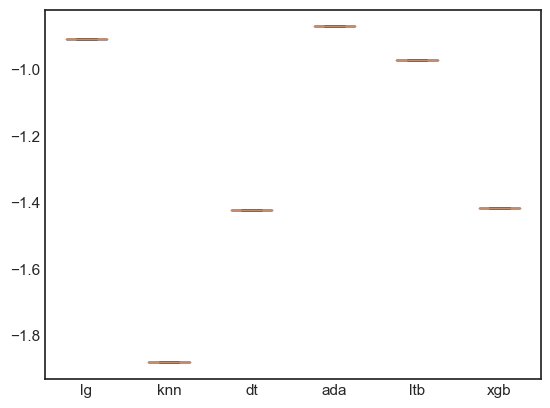

In [81]:
results_lst = []
model_dct = {}

for name, p in pipe_dict.items():
    cv = RandomizedSearchCV(estimator = p, param_distributions = param_dict[name]
                            , random_state=rand_int, scoring="r2")
    cv.fit(X_train, y_train)
    
    cv_results = cv.cv_results_['mean_test_score']
    results_lst.append(cv_results)
    
    model_dct[name] = cv
    print(name, ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)
    
plt.boxplot(results_lst, labels=pipe_dict.keys())
plt.show()

# Stats Model - Taylor Index

In [45]:
taylor_df = load_taylor()
taylor_df

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


GDPC1        GDPPOT  GDPDEF_PC1  FEDFUNDS    ffef_tr  gap_inf  \
DATE                                                                            
1954-07-01   2880.482   2727.099666         0.7      0.80   4.862188    -0.65   
1954-10-01   2936.852   2743.726730         0.8      0.85   5.719397    -0.60   
1955-01-01   3020.746   2760.136280         1.0      1.39   7.220957    -0.50   
1955-04-01   3069.910   2777.950765         1.3      1.43   8.204939    -0.35   
1955-07-01   3111.379   2795.471543         1.9      1.68   9.500343    -0.05   
...               ...           ...         ...       ...        ...      ...   
2022-04-01  21708.160  20153.810000         7.7      0.33  16.406219     2.85   
2022-07-01  21851.134  20245.660000         7.3      1.68  15.914983     2.65   
2022-10-01  21989.981  20334.210000         6.4      3.08  14.671392     2.20   
2023-01-01  22112.329  20420.680000         5.3      4.33  13.092000     1.65   
2023-04-01  22225.350  20511.890000         3.5      4.83  10.426748     0.75   

             gap_gdp  recession_flag chair_name  
DATE                                             
1954-07-01  2.812188           False     Martin  
1954-10-01  3.519397           False     Martin  
1955-01-01  4.720957           False     Martin  
1955-04-01  5.254939           False     Martin  
1955-07-01  5.650343           False     Martin  
...              ...             ...        ...  
2022-04-01  3.856219           False     Powell  
2022-07-01  3.964983           False     Powell  
2022-10-01  4.071392           False     Powell  
2023-01-01  4.142000           False     Powell  
2023-04-01  4.176748           False     Powell  

[276 rows x 9 columns]

In [46]:
train_df, test_df = time_split(taylor_df)

train_df:  (221, 9)
test_df:  (55, 9)


In [47]:
taylor_df.describe()

GDPC1        GDPPOT  GDPDEF_PC1    FEDFUNDS     ffef_tr  \
count    276.000000    276.000000  276.000000  276.000000  276.000000   
mean   10686.121225  10041.101050    3.247464    4.594058    9.225885   
std     5757.091030   5428.362902    2.253924    3.655726    3.582465   
min     2880.482000   2727.099666    0.100000    0.050000    1.060168   
25%     5527.792000   5225.612537    1.700000    1.745000    6.825312   
50%     9722.565000   9017.852858    2.400000    4.115000    8.137028   
75%    16276.424250  15060.514826    4.025000    6.317500   11.217137   
max    22225.350000  20511.890000   10.900000   19.080000   19.523598   

          gap_inf     gap_gdp  
count  276.000000  276.000000  
mean     0.623732    3.354690  
std      1.126962    1.245840  
min     -0.950000   -0.989832  
25%     -0.150000    2.609773  
50%      0.200000    3.335385  
75%      1.012500    4.122013  
max      4.450000    6.675894

In [48]:
X_train = train_df[['gap_inf', 'gap_gdp','recession_flag','chair_name']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['gap_inf', 'gap_gdp','recession_flag','chair_name']]
y_test = test_df['FEDFUNDS']

In [49]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
cat_columns_lst = ['recession_flag','chair_name']
num_columns_lst = ['gap_inf', 'gap_gdp']


ohe_categories = list()
for c in cat_columns_lst:
    ohe_categories.append(list(X_train[c].unique()))
    
ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                   sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')



numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
categorical_transformer = Pipeline( steps=[('transformer',transformer)])

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

In [51]:
t_fit = preprocessor.fit(X_train)

In [52]:
t_fit.get_feature_names_out()

array(['num__gap_inf', 'num__gap_gdp',
       'cat__onehotencoder__recession_flag_True',
       'cat__onehotencoder__chair_name_Burns',
       'cat__onehotencoder__chair_name_Miller',
       'cat__onehotencoder__chair_name_Volcker',
       'cat__onehotencoder__chair_name_Greenspan',
       'cat__onehotencoder__chair_name_Bernanke'], dtype=object)

In [53]:
X_train_trf = t_fit.transform(X_train)

In [54]:
#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)
X_train_trf

num__gap_inf  num__gap_gdp  \
DATE                                     
1954-07-01         -0.65      2.812188   
1954-10-01         -0.60      3.519397   
1955-01-01         -0.50      4.720957   
1955-04-01         -0.35      5.254939   
1955-07-01         -0.05      5.650343   
...                  ...           ...   
2008-07-01          0.00      3.329781   
2008-10-01         -0.05      1.941962   
2009-01-01         -0.30      1.150422   
2009-04-01         -0.65      0.870796   
2009-07-01         -0.95      0.874124   

            cat__onehotencoder__recession_flag_True  \
DATE                                                  
1954-07-01                                      0.0   
1954-10-01                                      0.0   
1955-01-01                                      0.0   
1955-04-01                                      0.0   
1955-07-01                                      0.0   
...                                             ...   
2008-07-01                                      1.0   
2008-10-01                                      1.0   
2009-01-01                                      1.0   
2009-04-01                                      1.0   
2009-07-01                                      0.0   

            cat__onehotencoder__chair_name_Burns  \
DATE                                               
1954-07-01                                   0.0   
1954-10-01                                   0.0   
1955-01-01                                   0.0   
1955-04-01                                   0.0   
1955-07-01                                   0.0   
...                                          ...   
2008-07-01                                   0.0   
2008-10-01                                   0.0   
2009-01-01                                   0.0   
2009-04-01                                   0.0   
2009-07-01                                   0.0   

            cat__onehotencoder__chair_name_Miller  \
DATE                                                
1954-07-01                                    0.0   
1954-10-01                                    0.0   
1955-01-01                                    0.0   
1955-04-01                                    0.0   
1955-07-01                                    0.0   
...                                           ...   
2008-07-01                                    0.0   
2008-10-01                                    0.0   
2009-01-01                                    0.0   
2009-04-01                                    0.0   
2009-07-01                                    0.0   

            cat__onehotencoder__chair_name_Volcker  \
DATE                                                 
1954-07-01                                     0.0   
1954-10-01                                     0.0   
1955-01-01                                     0.0   
1955-04-01                                     0.0   
1955-07-01                                     0.0   
...                                            ...   
2008-07-01                                     0.0   
2008-10-01                                     0.0   
2009-01-01                                     0.0   
2009-04-01                                     0.0   
2009-07-01                                     0.0   

            cat__onehotencoder__chair_name_Greenspan  \
DATE                                                   
1954-07-01                                       0.0   
1954-10-01                                       0.0   
1955-01-01                                       0.0   
1955-04-01                                       0.0   
1955-07-01                                       0.0   
...                                              ...   
2008-07-01                                       0.0   
2008-10-01                                       0.0   
2009-01-01                                       0.0   
2009-04-01                                       0.0   
2009-07

In [55]:
y_train

DATE
1954-07-01    0.80
1954-10-01    0.85
1955-01-01    1.39
1955-04-01    1.43
1955-07-01    1.68
              ... 
2008-07-01    2.01
2008-10-01    0.97
2009-01-01    0.15
2009-04-01    0.15
2009-07-01    0.16
Name: FEDFUNDS, Length: 221, dtype: float64

In [56]:
X_train_const = sm.add_constant(X_train_trf)
X_train_const

const  num__gap_inf  num__gap_gdp  \
DATE                                            
1954-07-01    1.0         -0.65      2.812188   
1954-10-01    1.0         -0.60      3.519397   
1955-01-01    1.0         -0.50      4.720957   
1955-04-01    1.0         -0.35      5.254939   
1955-07-01    1.0         -0.05      5.650343   
...           ...           ...           ...   
2008-07-01    1.0          0.00      3.329781   
2008-10-01    1.0         -0.05      1.941962   
2009-01-01    1.0         -0.30      1.150422   
2009-04-01    1.0         -0.65      0.870796   
2009-07-01    1.0         -0.95      0.874124   

            cat__onehotencoder__recession_flag_True  \
DATE                                                  
1954-07-01                                      0.0   
1954-10-01                                      0.0   
1955-01-01                                      0.0   
1955-04-01                                      0.0   
1955-07-01                                      0.0   
...                                             ...   
2008-07-01                                      1.0   
2008-10-01                                      1.0   
2009-01-01                                      1.0   
2009-04-01                                      1.0   
2009-07-01                                      0.0   

            cat__onehotencoder__chair_name_Burns  \
DATE                                               
1954-07-01                                   0.0   
1954-10-01                                   0.0   
1955-01-01                                   0.0   
1955-04-01                                   0.0   
1955-07-01                                   0.0   
...                                          ...   
2008-07-01                                   0.0   
2008-10-01                                   0.0   
2009-01-01                                   0.0   
2009-04-01                                   0.0   
2009-07-01                                   0.0   

            cat__onehotencoder__chair_name_Miller  \
DATE                                                
1954-07-01                                    0.0   
1954-10-01                                    0.0   
1955-01-01                                    0.0   
1955-04-01                                    0.0   
1955-07-01                                    0.0   
...                                           ...   
2008-07-01                                    0.0   
2008-10-01                                    0.0   
2009-01-01                                    0.0   
2009-04-01                                    0.0   
2009-07-01                                    0.0   

            cat__onehotencoder__chair_name_Volcker  \
DATE                                                 
1954-07-01                                     0.0   
1954-10-01                                     0.0   
1955-01-01                                     0.0   
1955-04-01                                     0.0   
1955-07-01                                     0.0   
...                                            ...   
2008-07-01                                     0.0   
2008-10-01                                     0.0   
2009-01-01                                     0.0   
2009-04-01                                     0.0   
2009-07-01                                     0.0   

            cat__onehotencoder__chair_name_Greenspan  \
DATE                                                   
1954-07-01                                       0.0   
1954-10-01                                       0.0   
1955-01-01                                       0.0   
1955-04-01                                       0.0   
1955-07-01                                       0.0   
...                                              ...   
2008-07-01                                       0.0   
2008-10-01                                       0.0   
2009-01-01                  

In [57]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

In [58]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     101.5
Date:                Wed, 15 Nov 2023   Prob (F-statistic):           3.42e-68
Time:                        07:02:07   Log-Likelihood:                -411.71
No. Observations:                 221   AIC:                             841.4
Df Residuals:                     212   BIC:                             872.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        0.1433      0.519      0.276      0.783      -0.881       1.167
num__gap_inf                                 2.0160      0.146     13.803      0.000       1.728       2.304
num__gap_gdp                                 0.6879      0.110      6.276      0.000       0.472       0.904
cat__onehotencoder__recession_flag_True      1.0690      0.340      3.145      0.002       0.399       1.739
cat__onehotencoder__chair_name_Burns        -0.5087      0.462     -1.100      0.273      -1.420       0.403
cat__onehotencoder__chair_name_Miller        0.0300      0.792      0.038      0.970      -1.530       1.590
cat__onehotencoder__chair_name_Volcker       5.5756      0.459     12.145      0.000       4.671       6.480
cat__onehotencoder__chair_name_Greenspan     1.7491      0.289      6.056      0.000       1.180       2.318
cat__onehotencoder__chair_name_Bernanke      0.3137      0.486      0.646      0.519      -0.644       1.271
==============================================================================
Omnibus:                        9.106   Durbin-Watson:                   0.559
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.072
Skew:                          -0.481   Prob(JB):                       0.0107
Kurtosis:                       3.242   Cond. No.                         32.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
train_pred = ols_result.predict(X_train_const)
train_pred

DATE
1954-07-01    0.767521
1954-10-01    1.354821
1955-01-01    2.382991
1955-04-01    3.052721
1955-07-01    3.929515
                ...   
2008-07-01    3.816668
2008-10-01    2.761165
2009-01-01    1.712660
2009-04-01    0.814713
2009-07-01   -0.856782
Length: 221, dtype: float64

In [60]:
t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)
train_pred_ols

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
DATE                                                                         
1954-07-01  0.767521  0.278088       0.219350       1.315692     -2.417498   
1954-10-01  1.354821  0.240679       0.880390       1.829251     -1.818339   
1955-01-01  2.382991  0.227106       1.935317       2.830665     -0.786279   
1955-04-01  3.052721  0.238721       2.582149       3.523292     -0.119864   
1955-07-01  3.929515  0.249974       3.436763       4.422268      0.753564   
...              ...       ...            ...            ...           ...   
2008-07-01  3.816668  0.471855       2.886540       4.746796      0.544207   
2008-10-01  2.761165  0.466719       1.841160       3.681169     -0.508432   
2009-01-01  1.712660  0.489718       0.747320       2.678001     -1.569982   
2009-04-01  0.814713  0.509674      -0.189964       1.819390     -2.479711   
2009-07-01 -0.856782  0.541898      -1.924981       0.211416     -4.171131   

            obs_ci_upper  
DATE                      
1954-07-01      3.952541  
1954-10-01      4.527980  
1955-01-01      5.552261  
1955-04-01      6.225306  
1955-07-01      7.105466  
...                  ...  
2008-07-01      7.089128  
2008-10-01      6.030762  
2009-01-01      4.995302  
2009-04-01      4.109138  
2009-07-01      2.457566  

[221 rows x 6 columns]

In [61]:
model_results(y_train, train_pred_ols['mean'], X_train.shape[0], 2 )

r-squared:  0.7929
adj r-squared 0.792
mse:  2.4302
rmse:  1.5589
rmse:  1.5589063056926882


## Test

X_test = test_df[['gap_inf','gap_gdp']]
X_test_const = sm.add_constant(X_test)
X_test_const.shape

y_test = test_df['FEDFUNDS']
y_test.shape

test_pred_ols = ols_result.predict(X_test_const)
test_pred_ols

In [62]:
X_test_trf = t_fit.transform(X_test)

In [71]:
#X_train_trf.columns = 
X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)
X_test_trf.head()

num__gap_inf  num__gap_gdp  \
DATE                                     
2009-10-01         -0.90      1.258090   
2010-01-01         -0.70      1.347804   
2010-04-01         -0.40      1.689976   
2010-07-01         -0.30      1.925735   
2010-10-01         -0.15      2.019256   

            cat__onehotencoder__recession_flag_True  \
DATE                                                  
2009-10-01                                      0.0   
2010-01-01                                      0.0   
2010-04-01                                      0.0   
2010-07-01                                      0.0   
2010-10-01                                      0.0   

            cat__onehotencoder__chair_name_Burns  \
DATE                                               
2009-10-01                                   0.0   
2010-01-01                                   0.0   
2010-04-01                                   0.0   
2010-07-01                                   0.0   
2010-10-01                                   0.0   

            cat__onehotencoder__chair_name_Miller  \
DATE                                                
2009-10-01                                    0.0   
2010-01-01                                    0.0   
2010-04-01                                    0.0   
2010-07-01                                    0.0   
2010-10-01                                    0.0   

            cat__onehotencoder__chair_name_Volcker  \
DATE                                                 
2009-10-01                                     0.0   
2010-01-01                                     0.0   
2010-04-01                                     0.0   
2010-07-01                                     0.0   
2010-10-01                                     0.0   

            cat__onehotencoder__chair_name_Greenspan  \
DATE                                                   
2009-10-01                                       0.0   
2010-01-01                                       0.0   
2010-04-01                                       0.0   
2010-07-01                                       0.0   
2010-10-01                                       0.0   

            cat__onehotencoder__chair_name_Bernanke  
DATE                                                 
2009-10-01                                      1.0  
2010-01-01                                      1.0  
2010-04-01                                      1.0  
2010-07-01                                      1.0  
2010-10-01                                      1.0

In [72]:
X_test_const = sm.add_constant(X_test_trf)
X_test_const.head()

const  num__gap_inf  num__gap_gdp  \
DATE                                            
2009-10-01    1.0         -0.90      1.258090   
2010-01-01    1.0         -0.70      1.347804   
2010-04-01    1.0         -0.40      1.689976   
2010-07-01    1.0         -0.30      1.925735   
2010-10-01    1.0         -0.15      2.019256   

            cat__onehotencoder__recession_flag_True  \
DATE                                                  
2009-10-01                                      0.0   
2010-01-01                                      0.0   
2010-04-01                                      0.0   
2010-07-01                                      0.0   
2010-10-01                                      0.0   

            cat__onehotencoder__chair_name_Burns  \
DATE                                               
2009-10-01                                   0.0   
2010-01-01                                   0.0   
2010-04-01                                   0.0   
2010-07-01                                   0.0   
2010-10-01                                   0.0   

            cat__onehotencoder__chair_name_Miller  \
DATE                                                
2009-10-01                                    0.0   
2010-01-01                                    0.0   
2010-04-01                                    0.0   
2010-07-01                                    0.0   
2010-10-01                                    0.0   

            cat__onehotencoder__chair_name_Volcker  \
DATE                                                 
2009-10-01                                     0.0   
2010-01-01                                     0.0   
2010-04-01                                     0.0   
2010-07-01                                     0.0   
2010-10-01                                     0.0   

            cat__onehotencoder__chair_name_Greenspan  \
DATE                                                   
2009-10-01                                       0.0   
2010-01-01                                       0.0   
2010-04-01                                       0.0   
2010-07-01                                       0.0   
2010-10-01                                       0.0   

            cat__onehotencoder__chair_name_Bernanke  
DATE                                                 
2009-10-01                                      1.0  
2010-01-01                                      1.0  
2010-04-01                                      1.0  
2010-07-01                                      1.0  
2010-10-01                                      1.0

In [65]:
X_test_const.shape[0]

55

In [66]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(55, 6)

In [67]:
model_results(y_test, test_pred_ols['mean'], X_test.shape[0], 2 )

r-squared:  -5.0077
adj r-squared -5.121
mse:  7.1127
rmse:  2.667
rmse:  2.6669676940234295


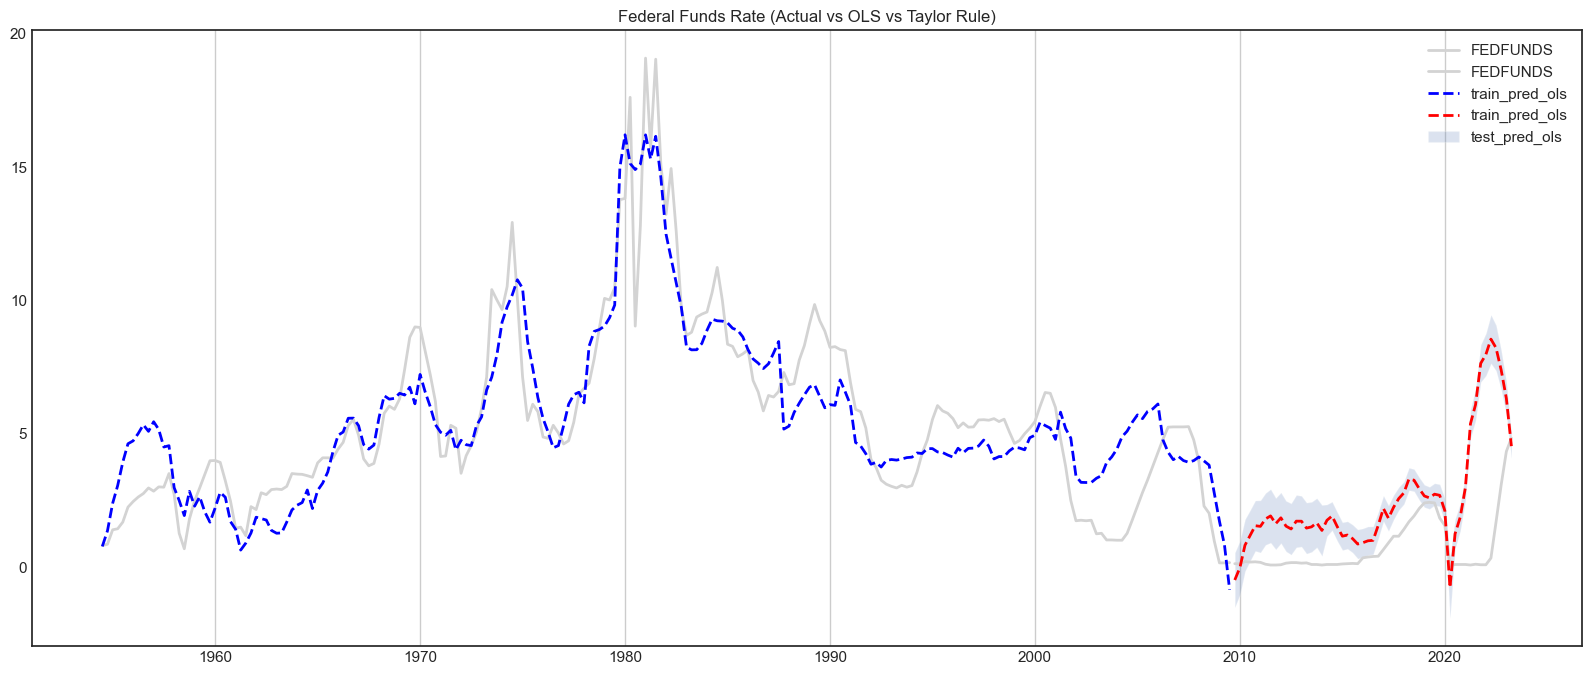

In [68]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

In [69]:
pd.DataFrame(y_test).describe()

FEDFUNDS
count  55.000000
mean    0.747091
std     1.098117
min     0.050000
25%     0.090000
50%     0.160000
75%     1.150000
max     4.830000

In [70]:
pd.DataFrame(test_pred_ols).describe()

mean    mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
count  55.000000  55.000000      55.000000      55.000000     55.000000   
mean    2.528952   0.348357       1.842264       3.215640     -0.690893   
std     2.167486   0.119823       2.214106       2.145998      2.177858   
min    -0.778958   0.208471      -1.922302       0.364386     -4.118283   
25%     1.394168   0.244474       0.552108       2.092117     -1.886416   
50%     1.796987   0.281399       0.973182       2.576637     -1.444962   
75%     2.751053   0.482810       2.336003       3.166103     -0.413776   
max     8.541604   0.580019       7.630434       9.452773      5.274482   

       obs_ci_upper  
count     55.000000  
mean       5.748797  
std        2.158372  
min        2.560367  
25%        4.670032  
50%        5.002706  
75%        5.915882  
max       11.808726

# LGBM

In [82]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_lgbm = ltb_model.predict(X_train_trf, pred_contrib=False, raw_score=False)

<Axes: >

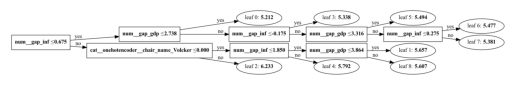

In [83]:
ltb.plot_tree(ltb_model)

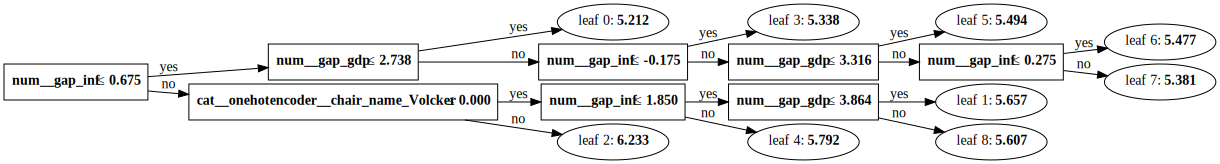

In [84]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

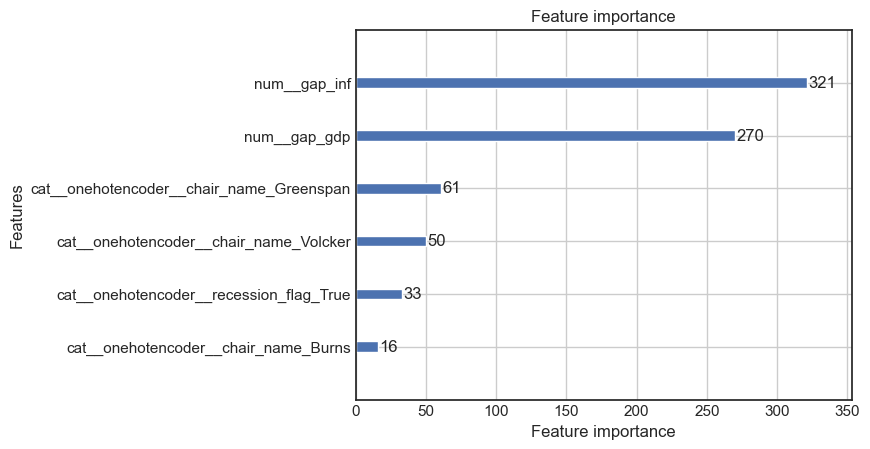

In [85]:
ltb.plot_importance(ltb_model)

In [86]:
model_results(y_train, train_pred_lgbm, X_train.shape[0], 2 )

r-squared:  0.9072
adj r-squared 0.9067
mse:  1.0895
rmse:  1.0438
rmse:  1.0437686505590047


## Test

In [87]:
test_pred_lgbm = ltb_model.predict(X_test_trf, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(55,)

In [88]:
model_results(y_test, test_pred_lgbm, X_train.shape[0], 2 )

r-squared:  -7.074
adj r-squared -7.1109
mse:  9.5591
rmse:  3.0918
rmse:  3.09178415372361


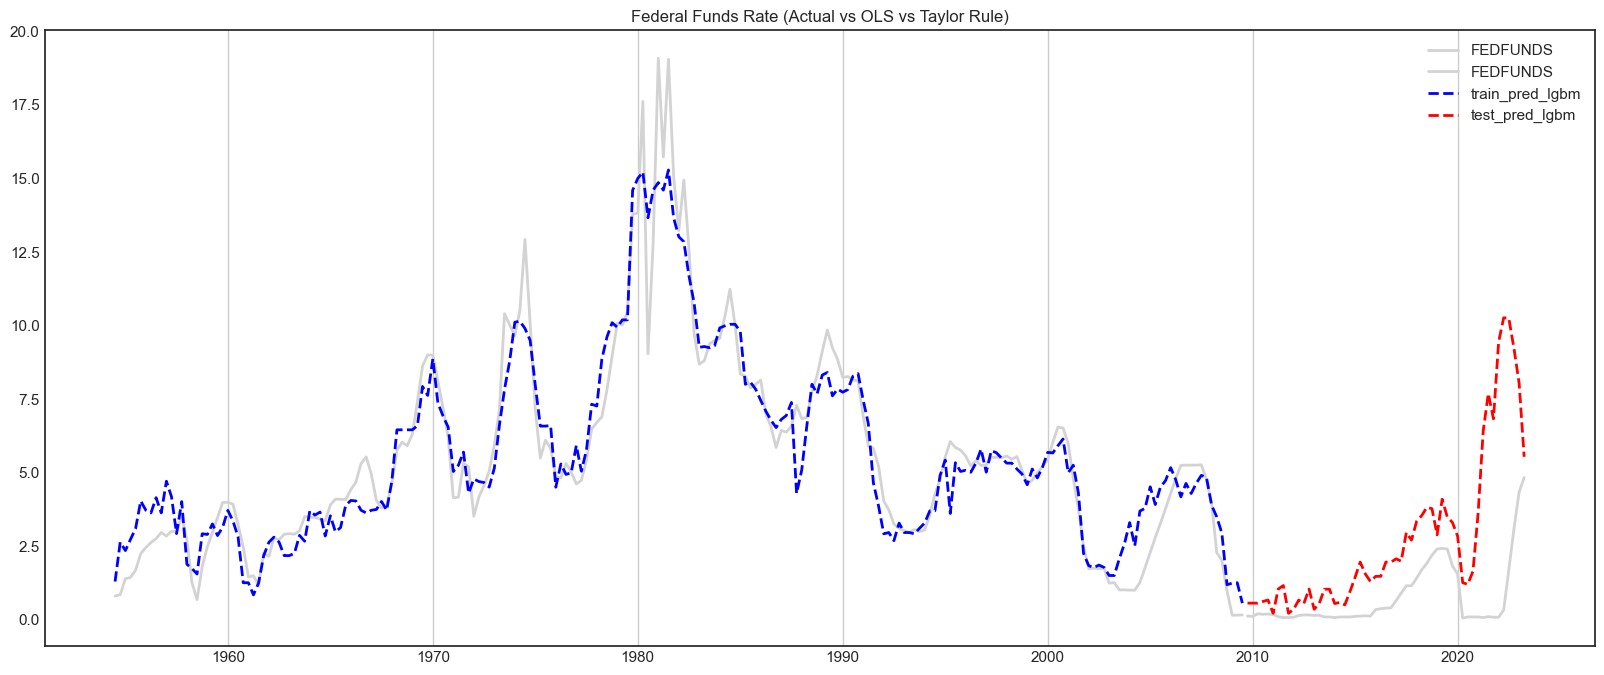

In [89]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# XGB

In [90]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_xgb = xgb_model.predict(X_train_trf)
xgb_model.score(X_train_trf, y_train)

0.9999555021221583

In [91]:
model_results(y_train, train_pred_xgb, X_train.shape[0], 2 )

r-squared:  1.0
adj r-squared 1.0
mse:  0.0005
rmse:  0.0229
rmse:  0.022851835441256338


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

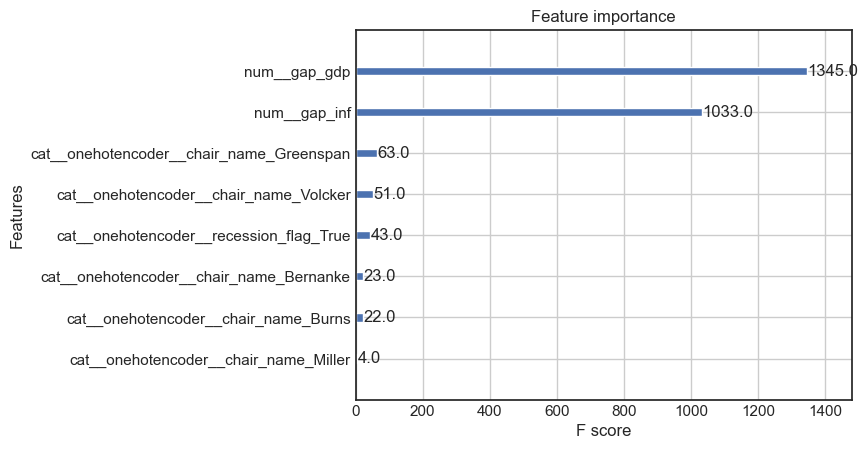

In [92]:
xgb.plot_importance(xgb_model)

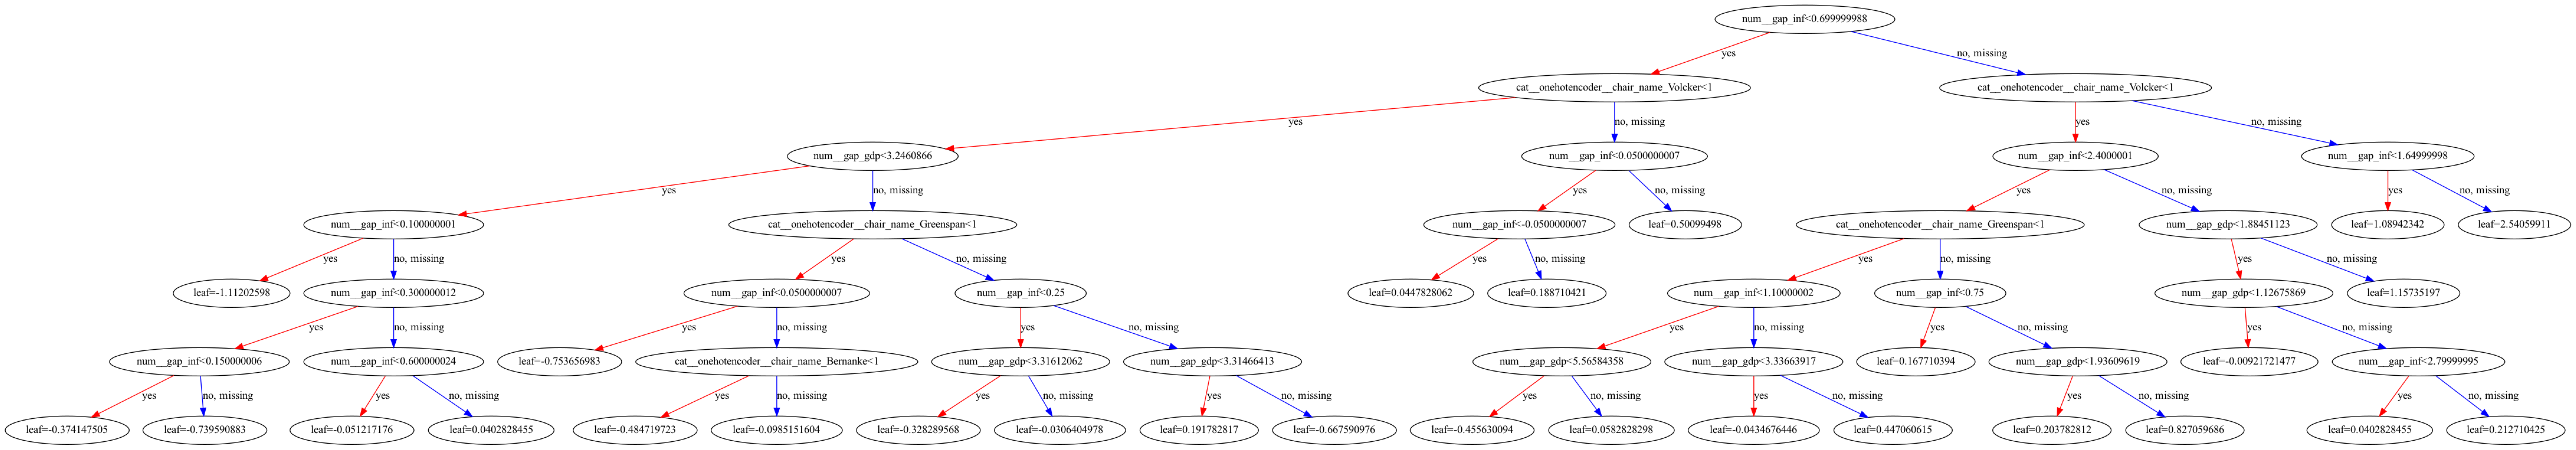

In [93]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

## Test

In [94]:
test_pred_xgb = xgb_model.predict(X_test_trf)
test_pred_xgb.shape

(55,)

In [95]:
model_results(y_test, test_pred_xgb, X_train.shape[0], 2 )

r-squared:  -6.7122
adj r-squared -6.7474
mse:  9.1307
rmse:  3.0217
rmse:  3.02171222569511


# AdaBoostRegressor

In [96]:
ada_model = AdaBoostRegressor().fit(X_train_trf, y_train)
train_pred_ada = ada_model.predict(X_train_trf)

In [98]:
model_results(y_train, train_pred_ada, X_train_trf.shape[0], 2 )

r-squared:  0.813
adj r-squared 0.8121
mse:  2.1947
rmse:  1.4815
rmse:  1.4814661359161585


In [99]:
test_pred_ada = ada_model.predict(X_test_trf)

In [100]:
model_results(y_test, test_pred_ada, X_test.shape[0], 2 )

r-squared:  -9.1041
adj r-squared -9.2947
mse:  11.9626
rmse:  3.4587
rmse:  3.458699927296607


# tsa.SARIMAX

In [101]:
taylor2006_df = load_taylor()
#taylor2006_df = taylor2006_df.query('index < "2007-01-01"')
taylor2006_df

gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
fed_df: (831, 2)


GDPC1        GDPPOT  GDPDEF_PC1  FEDFUNDS    ffef_tr  gap_inf  \
DATE                                                                            
1954-07-01   2880.482   2727.099666         0.7      0.80   4.862188    -0.65   
1954-10-01   2936.852   2743.726730         0.8      0.85   5.719397    -0.60   
1955-01-01   3020.746   2760.136280         1.0      1.39   7.220957    -0.50   
1955-04-01   3069.910   2777.950765         1.3      1.43   8.204939    -0.35   
1955-07-01   3111.379   2795.471543         1.9      1.68   9.500343    -0.05   
...               ...           ...         ...       ...        ...      ...   
2022-04-01  21708.160  20153.810000         7.7      0.33  16.406219     2.85   
2022-07-01  21851.134  20245.660000         7.3      1.68  15.914983     2.65   
2022-10-01  21989.981  20334.210000         6.4      3.08  14.671392     2.20   
2023-01-01  22112.329  20420.680000         5.3      4.33  13.092000     1.65   
2023-04-01  22225.350  20511.890000         3.5      4.83  10.426748     0.75   

             gap_gdp  recession_flag chair_name  
DATE                                             
1954-07-01  2.812188           False     Martin  
1954-10-01  3.519397           False     Martin  
1955-01-01  4.720957           False     Martin  
1955-04-01  5.254939           False     Martin  
1955-07-01  5.650343           False     Martin  
...              ...             ...        ...  
2022-04-01  3.856219           False     Powell  
2022-07-01  3.964983           False     Powell  
2022-10-01  4.071392           False     Powell  
2023-01-01  4.142000           False     Powell  
2023-04-01  4.176748           False     Powell  

[276 rows x 9 columns]

In [102]:
train2006_df, test2006_df = time_split(taylor2006_df)

train_df:  (221, 9)
test_df:  (55, 9)


In [105]:
model_results(train2006_df['FEDFUNDS'], train2006_df['ffef_tr'], train2006_df.shape[0], 2 )

r-squared:  -1.1326
adj r-squared -1.1423
mse:  25.027
rmse:  5.0027
rmse:  5.002697671477806


In [106]:
model_results(test2006_df['FEDFUNDS'], test2006_df['ffef_tr'], test2006_df.shape[0], 2 )

r-squared:  -43.0596
adj r-squared -43.8909
mse:  52.1638
rmse:  7.2225
rmse:  7.222450773639554


In [109]:
X_train = train2006_df[['gap_inf', 'gap_gdp','recession_flag','chair_name']]
X_train_trf = t_fit.transform(X_train)


y_train = train2006_df['FEDFUNDS']

In [110]:
model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)

In [111]:
result_model = model.fit(disp=False)

In [112]:
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  221
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -325.407
Date:                Wed, 15 Nov 2023   AIC                            670.815
Time:                        19:37:58   BIC                            704.796
Sample:                    07-01-1954   HQIC                           684.536
                         - 07-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1509      0.218      9.884      0.000       1.724       2.577
x2             0.6730      0.119      5.649      0.000       0.439       0.906
x3             0.4531      0.260      1.745      0.081      -0.056       0.962
x4            -0.1818      1.144     -0.159      0.874      -2.423       2.060
x5            -0.5399      1.341     -0.403      0.687      -3.168       2.088
x6             4.0819      0.894      4.566      0.000       2.330       5.834
x7             2.2429      0.828      2.709      0.007       0.620       3.866
x8             1.7945      1.827      0.982      0.326      -1.786       5.375
ar.L1          0.7897      0.051     15.625      0.000       0.691       0.889
sigma2         1.1080      0.056     19.736      0.000       0.998       1.218
===================================================================================
Ljung-Box (L1) (Q):                   3.40   Jarque-Bera (JB):              1998.38
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.62
Prob(H) (two-sided):                  0.27   Kurtosis:                        17.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [113]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [114]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS        mean   mean_se  mean_ci_lower  mean_ci_upper
1954-07-01  0.494437  1.715811      -2.868491       3.857364
1954-10-01  1.077905  1.715811      -2.285022       4.440833
1955-01-01  2.101598  1.715811      -1.261330       5.464525
1955-04-01  2.783577  1.715811      -0.579350       6.146504
1955-07-01  3.694929  1.715811       0.332001       7.057856
...              ...       ...            ...            ...
2008-07-01  4.488360  1.715811       1.125433       7.851287
2008-10-01  3.446866  1.715811       0.083938       6.809793
2009-01-01  2.376473  1.715811      -0.986454       5.739400
2009-04-01  1.435492  1.715811      -1.927435       4.798420
2009-07-01  0.339396  1.715811      -3.023531       3.702323

[221 rows x 4 columns]

## Test

In [134]:
#X_test = test2006_df[['gap_inf','gap_gdp']]
#y_test = test2006_df['FEDFUNDS']

X_test = test2006_df[['gap_inf', 'gap_gdp','recession_flag','chair_name']]
X_test_trf = t_fit.transform(X_test)


y_test = train2006_df['FEDFUNDS']

In [135]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

In [136]:
test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [138]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(55, 4)

In [139]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

lower FEDFUNDS  upper FEDFUNDS
2009-10-01       -0.146313        1.273640
2010-01-01        0.179334        1.988671
2010-04-01        0.975847        2.990268
2010-07-01        1.309202        3.441559
2010-10-01        1.674262        3.876975

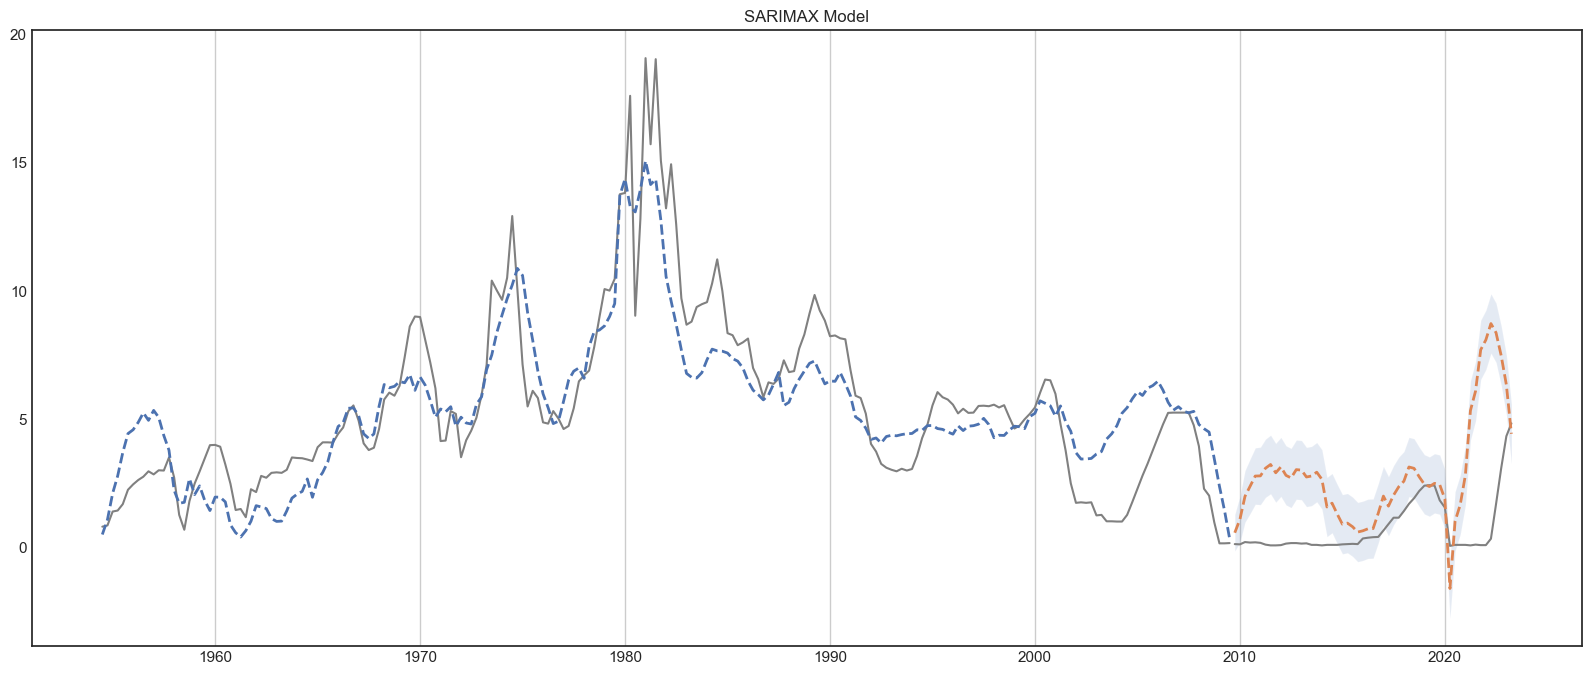

In [140]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train2006_df.index, train2006_df['FEDFUNDS'], 'gray')
ax.plot(test2006_df.index, test2006_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [141]:
print('SARIMAX RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX RMSE(Train): 1.7283505879924284
SARIMAX RMSE(Test): 2.9384781095911165


In [142]:
print('SARIMAX R-Squard(Train):' , r2_score(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX R-Squard(Test):' , r2_score(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX R-Squard(Train): 0.7454572059740565
SARIMAX R-Squard(Test): -6.293169873751995


In [ ]:
#print('SARIMAX R-Squard:' , r2_score(test_df['real_rate'], test_pred['mean']))